In [1]:
from pyspark.sql import SparkSession 
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression 
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn import metrics

In [4]:
spark = SparkSession.builder.master('local').appName('Predicting Fire Dept Calls').config('spark.executor.memory','6gb').getOrCreate()

In [5]:
url = 'https://data.sfgov.org/resource/RowID.json'
df = spark.read.format('com.databricks.spark.csv').options(header='True', inferschema='True').load('C:/Users/Dylan/Desktop/Datasets/Fire_Department_Calls_for_Service.csv')

In [6]:
df.show(2)

+-----------+-------+---------------+------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+----------------------+
|Call Number|Unit ID|Incident Number|   Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|Transport DtTm|Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|         City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|N

In [7]:
df.select('Call Type Group').distinct().show()

+--------------------+
|     Call Type Group|
+--------------------+
|               Alarm|
|                null|
|Potentially Life-...|
|Non Life-threatening|
|                Fire|
+--------------------+



In [8]:
df.groupBy('Call Type Group').count().show()

+--------------------+-------+
|     Call Type Group|  count|
+--------------------+-------+
|               Alarm| 747473|
|                null|2817409|
|Potentially Life-...|1526807|
|Non Life-threatening| 770183|
|                Fire| 132387|
+--------------------+-------+



In [9]:
df2 = df.groupBy('Call Type Group').count()
graphDF = df2.toPandas()
graphDF = graphDF.sort_values('count', ascending=False)

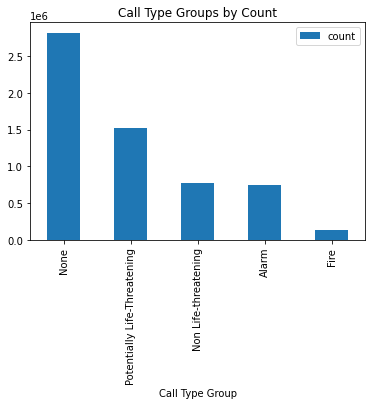

In [10]:
graphDF.plot(x='Call Type Group', y ='count', kind='bar')
plt.title('Call Type Groups by Count')
plt.show()

In [11]:
df.groupBy('Call Type').count().orderBy('count', ascending=False).show(100)

+--------------------+-------+
|           Call Type|  count|
+--------------------+-------+
|    Medical Incident|3936048|
|      Structure Fire| 711137|
|              Alarms| 661567|
|   Traffic Collision| 243958|
|               Other|  99043|
|Citizen Assist / ...|  89166|
|        Outside Fire|  77034|
|        Water Rescue|  31747|
|        Vehicle Fire|  27083|
|Gas Leak (Natural...|  26500|
|   Electrical Hazard|  19364|
|Elevator / Escala...|  16462|
|Smoke Investigati...|  13644|
|Odor (Strange / U...|  13368|
|          Fuel Spill|   6681|
|              HazMat|   4296|
|Industrial Accidents|   3219|
|           Explosion|   2963|
|Train / Rail Inci...|   1600|
|  Aircraft Emergency|   1512|
|       Assist Police|   1477|
|   High Angle Rescue|   1373|
|Watercraft in Dis...|   1132|
|Extrication / Ent...|    869|
|Confined Space / ...|    677|
|Mutual Aid / Assi...|    569|
|           Oil Spill|    518|
|         Marine Fire|    492|
|  Suspicious Package|    360|
|      A

In [12]:
fireIndicator = df.select(df['Call Type'], F.when(df['Call Type'].like('%Fire%'), 1).otherwise(0).alias('Fire Indicator'))
fireIndicator.show()

+--------------------+--------------+
|           Call Type|Fire Indicator|
+--------------------+--------------+
|        Outside Fire|             1|
|              Alarms|             0|
|              Alarms|             0|
|              Alarms|             0|
|              Alarms|             0|
|              Alarms|             0|
|              Alarms|             0|
|              Alarms|             0|
|      Structure Fire|             1|
|    Medical Incident|             0|
|               Other|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|        Outside Fire|             1|
|              Alarms|             0|
|        Outside Fire|             1|
|Citizen Assist / ...|             0|
|              Alarms|             0|
|              Alarms|             0|
|               Other|             0|
+--------------------+--------------+
only showing top 20 rows



In [13]:
fireIndicator.groupBy('Fire Indicator').count().show()

+--------------+-------+
|Fire Indicator|  count|
+--------------+-------+
|             1| 815830|
|             0|5178429|
+--------------+-------+



In [14]:
df = df.withColumn('fireIndicator', F.when(df['Call Type'].like('%Fire%'), 1).otherwise(0))
df.printSchema()

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [15]:
df = df.select('fireIndicator',
               'zipcode of Incident',
               'Battalion',
               'Station Area',
               'Box',
               'Number of Alarms',
               'Unit sequence in call dispatch',
               'Neighborhooods - Analysis Boundaries',
               'Fire Prevention District',
               'Supervisor District')
df.show(5)

+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
|fireIndicator|zipcode of Incident|Battalion|Station Area| Box|Number of Alarms|Unit sequence in call dispatch|Neighborhooods - Analysis Boundaries|Fire Prevention District|Supervisor District|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
|            1|              94102|      B02|          36|3265|               1|                             1|                        Hayes Valley|                       2|                  5|
|            0|              94107|      B03|          29|2431|               1|                             1|                        Potrero Hill|                       3|                 10|
|            0|              9

In [16]:
print('Total Rows')
print(df.count())
print('Rows without Null values')
print(df.dropna().count())
print('Row with Null Values')
print(df.count() - df.dropna().count())

Total Rows
5994259
Rows without Null values
5976685
Row with Null Values
17574


In [17]:
df =df.dropna()

In [18]:
df.groupBy('fireIndicator').count().orderBy('count', ascending=False).show()

+-------------+-------+
|fireIndicator|  count|
+-------------+-------+
|            0|5162021|
|            1| 814664|
+-------------+-------+



In [19]:
column_names = df.columns[1:]

In [20]:
column_names

['zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District']

In [21]:
categoricalColumns = column_names
indexers = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"_Index")
    indexers += [stringIndexer]

In [22]:
indexers

[StringIndexer_5c8e2753a3ce,
 StringIndexer_8a441b4f6b94,
 StringIndexer_c6b5ed9f0929,
 StringIndexer_85018cd38e7f,
 StringIndexer_4a88d45a73d7,
 StringIndexer_e6392024020d,
 StringIndexer_96701a44ef81,
 StringIndexer_4cb6a210f676,
 StringIndexer_53bf1e448ce1]

In [23]:
models = []
for model in indexers:
    indexer_model = model.fit(df)
    models += [indexer_model]
for i in models:
    df = i.transform(df)

In [24]:
df.columns

['fireIndicator',
 'zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District',
 'zipcode of Incident_Index',
 'Battalion_Index',
 'Station Area_Index',
 'Box_Index',
 'Number of Alarms_Index',
 'Unit sequence in call dispatch_Index',
 'Neighborhooods - Analysis Boundaries_Index',
 'Fire Prevention District_Index',
 'Supervisor District_Index']

In [25]:
df = df.select('fireIndicator',
               'zipcode of Incident_Index',
               'Battalion_Index',
               'Station Area_Index',
               'Box_Index',
               'Number of Alarms_Index',
               'Unit sequence in call dispatch_Index',
               'Neighborhooods - Analysis Boundaries_Index',
               'Fire Prevention District_Index',
               'Supervisor District_Index')

In [26]:
features = df.columns[1:]
features

['zipcode of Incident_Index',
 'Battalion_Index',
 'Station Area_Index',
 'Box_Index',
 'Number of Alarms_Index',
 'Unit sequence in call dispatch_Index',
 'Neighborhooods - Analysis Boundaries_Index',
 'Fire Prevention District_Index',
 'Supervisor District_Index']

In [27]:
feature_vectors = VectorAssembler(
    inputCols=features,
    outputCol='features'
)

df = feature_vectors.transform(df)
df

DataFrame[fireIndicator: int, zipcode of Incident_Index: double, Battalion_Index: double, Station Area_Index: double, Box_Index: double, Number of Alarms_Index: double, Unit sequence in call dispatch_Index: double, Neighborhooods - Analysis Boundaries_Index: double, Fire Prevention District_Index: double, Supervisor District_Index: double, features: vector]

In [28]:
df = df.drop('zipcode of Incident_Index',
            'Battalion_Index',
            'Station Area_Index',
            'Box_Index',
            'Number of Alarms_Index',
            'Unit sequence in call dispatch_Index',
            'Neighborhooods - Analysis Boundaries_Index',
            'Fire Prevention District_Index',
            'Supervisor District_Index')
df = df.withColumnRenamed('fireIndicator', 'label')
df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(9,[2,3,6,8],[2.0...|
|    0|[7.0,1.0,25.0,110...|
|    0|[3.0,0.0,3.0,5.0,...|
|    0|[0.0,1.0,1.0,6.0,...|
|    0|[2.0,3.0,17.0,677...|
|    0|[0.0,2.0,1.0,27.0...|
|    0|[2.0,3.0,1.0,122....|
|    0|[9.0,2.0,9.0,100....|
|    1|[1.0,0.0,2.0,41.0...|
|    0|[22.0,5.0,37.0,47...|
|    0|[1.0,1.0,25.0,141...|
|    0|[11.0,8.0,4.0,96....|
|    0|[20.0,7.0,38.0,12...|
|    1|[1.0,0.0,25.0,151...|
|    0|[7.0,1.0,8.0,14.0...|
|    1|[2.0,2.0,11.0,981...|
|    0|[0.0,0.0,2.0,47.0...|
|    0|[3.0,7.0,3.0,407....|
|    0|[12.0,8.0,13.0,88...|
|    0|[1.0,2.0,0.0,32.0...|
+-----+--------------------+
only showing top 20 rows



In [40]:
print(df['label'])

Column<'label'>


In [29]:
(trainDF, testDF) = df.randomSplit([0.75,0.25], seed= 12345)

In [30]:
logreg = LogisticRegression(labelCol='label',
                            featuresCol='features',
                            maxIter=10
                            )
LogisticRegressionModel = logreg.fit(trainDF)

In [31]:
df_predicted = LogisticRegressionModel.transform(df)

In [32]:
df_predicted.crosstab('label', 'prediction').show()

+----------------+-------+------+
|label_prediction|    0.0|   1.0|
+----------------+-------+------+
|               1| 587111|227553|
|               0|5119010| 43011|
+----------------+-------+------+



In [33]:
actual = df_predicted.select('label').toPandas()
prediction = df_predicted.select('prediction').toPandas()

In [34]:
metrics.accuracy_score(actual, prediction)

0.8945699831930243